In this notebook we will visualize the fiber products that occur in The Residual Finiteness of $A_{2,3,2n}$ Triangle Artin Groups by Greyson Meyer.

In [75]:
import turtle
import math
import tkinter as tkinter
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image

# The Functions

The fiber_product function calculates the fiber product of two graphs that combinatorially immerse into $\tilde{U}$.

In [76]:
def fiber_product(graph1, graph2):

  new_x_arrows = []
  new_y_arrows = []
  new_d_arrows = []
  new_vertices = []

  # Here we find the x arrows that arise in the fiber product
  for arrow in graph1[0]:
    for other_arrow in graph2[0]:

      first_value = (arrow[0],other_arrow[0])
      second_value = (arrow[1],other_arrow[1])
      new_x_arrow = (first_value, second_value)
      new_x_arrows.append(new_x_arrow)

      if first_value not in new_vertices:
        new_vertices.append(first_value)

      if second_value not in new_vertices:
        new_vertices.append(second_value)

  # Here we find the y arrows that arise in the fiber product
  for arrow in graph1[1]:
    for other_arrow in graph2[1]:

      first_value = (arrow[0],other_arrow[0])
      second_value = (arrow[1],other_arrow[1])
      new_y_arrow = (first_value, second_value)
      new_y_arrows.append(new_y_arrow)

      if first_value not in new_vertices:
        new_vertices.append(first_value)

      if second_value not in new_vertices:
        new_vertices.append(second_value)

  # Here we find the delta arrows that arise in the fiber product
  for arrow in graph1[2]:
    for other_arrow in graph2[2]:

      first_value = (arrow[0],other_arrow[0])
      second_value = (arrow[1],other_arrow[1])
      new_d_arrow = (first_value, second_value)
      new_d_arrows.append(new_d_arrow)

      if first_value not in new_vertices:
        new_vertices.append(first_value)

      if second_value not in new_vertices:
        new_vertices.append(second_value)

  new_graph = [new_x_arrows, new_y_arrows, new_d_arrows, new_vertices]
  return new_graph

We display the graph using Python's networkx package.

In [107]:
def draw_graph(graph, ax=None):
    x_arrows, y_arrows, d_arrows, vertices = graph

    G = nx.MultiDiGraph()
    G.add_nodes_from(vertices)

    for u,v in x_arrows:
        G.add_edge(u, v, color="red")
    for u,v in y_arrows:
        G.add_edge(u, v, color="green")
    for u,v in d_arrows:
        G.add_edge(u, v, color="yellow")

    colors = [data["color"] for u,v,k,data in G.edges(data=True, keys=True)]
    pos = nx.circular_layout(G)

    if ax is None:
        plt.figure(figsize=(8,8))
        ax = plt.gca()

    nx.draw_networkx_nodes(G, pos, node_color="blue", node_size=500, ax=ax)

    # Labels offset
    label_pos = {}
    label_offset = 0.1
    for node, (x, y) in pos.items():
        label_pos[node] = (x, y + label_offset)

    nx.draw_networkx_labels(
        G, label_pos,
        labels={n: str(n) for n in G.nodes()},
        font_color="black",
        font_size=10,
        ax=ax
    )

    for (u,v,k), c in zip(G.edges(keys=True), colors):
        rad = 0.2 if c == "green" else 0.0
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u,v)],
            edge_color=c,
            connectionstyle=f'arc3,rad={rad}',
            arrows=True,
            arrowstyle='-|>',
            arrowsize=20,
            width=2,
            ax=ax
        )

    ax.axis("off")
    return pos, G

Later on we will want to display the calculated graph alongside the graph from the paper that is its supergraph. To do this, we use the following function.

In [108]:
def display_graph_with_image(graph, image, description):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Draw the graph in the left subplot
    pos, G = draw_graph(graph, ax=axes[0])

    # Image + description in the right subplot
    axes[1].imshow(image)
    axes[1].axis("off")
    axes[1].set_title(description, fontsize=12)

    plt.show()

Computing the fiber product of two graphs often results in many connected components. The find_incidence function below returns all of the vertices in "graph" that share an edge with "vertex". This will be a key tool used to isolate connected components of fiber products later on.

In [79]:
def find_incidence (vertex, graph):

  x_edges = graph[0]
  y_edges = graph[1]
  d_edges = graph[2]
  incidence = []

  for j in x_edges:
    if vertex == j[0] and j[1] not in incidence:
      incidence.append(j[1])
    if vertex == j[1] and j[0] not in incidence:
      incidence.append(j[0])
    for j in y_edges:
      if vertex == j[0] and j[1] not in incidence:
        incidence.append(j[1])
      if vertex == j[1] and j[0] not in incidence:
        incidence.append(j[0])
    for j in d_edges:
      if vertex == j[0] and j[1] not in incidence:
        incidence.append(j[1])
      if vertex == j[1] and j[0] not in incidence:
        incidence.append(j[0])
        
  return incidence

The split function below returns a dictionary of the connected components present in "graph". We are only interested in connected components that have more than one vertex since $\sigma(W)$ contains no length-one loops, forcing every connected component that combinatorially immerses into $\sigma(W)$ with one vertex to be homotopically trivial.

In [80]:
def split(graph):

  x_edges = graph[0]
  y_edges = graph[1]
  d_edges = graph[2]
  vertices = graph[3]
  d = dict()

  # for each vertex it puts all of the vertices in the connected component containing that vertex in the 3rd position, including the vertex itself
  for i in vertices:
    d[i] = [[], [], [], []]
    d[i][3] = find_incidence(i, graph)
    d[i][3].append(i)

  # All of the edges touching that vertex are added to the other indices of d[k]
  for k in d:
    for edge in x_edges:
      if k == edge[0] or k == edge[1]:
        d[k][0].append(edge)

    for edge in y_edges:
      if k == edge[0] or k == edge[1]:
        d[k][1].append(edge)

    for edge in d_edges:
      if k == edge[0] or k == edge[1]:
        d[k][2].append(edge)

# This is where we find the redundant elements of the dictionary and mark them for deletion
  keys_to_delete = []
  for j in vertices:
    for k in vertices:
      # if j and k both share vertices, that means that they are part of the same connected component. So j absorbs all of k's edge info and then k is later deleted.
      if (j != k) and (len(set(d[j][3]) & set(d[k][3])) != 0):
        d[j][0] = list(set(d[j][0]) | set(d[k][0]))
        d[j][1] = list(set(d[j][1]) | set(d[k][1]))
        d[j][2] = list(set(d[j][2]) | set(d[k][2]))
        d[j][3] = list(set(d[j][3]) | set(d[k][3]))
        d[k][3] = []
        keys_to_delete.append(k)

  for i in keys_to_delete:
    del d[i]
    
  return d

Everybody likes dictionaries with readable keys! The readable_keys function below does well to keep us all sane.

In [81]:
def readable_keys(d):
  # Replaces the dictionary keys with numbers to make the prompt in check_fiber easier to understand

  better_d = dict()
  key_list = list(d.keys())
  for key in key_list:
    key_index = key_list.index(key)
    better_d[key_index] = d[key]
  return better_d

The what_subgraph function below tells us which column of Table 1 in the paper that an inputted connected component "graph" belongs. The criteria for deciding which column is somewhat arbitrary since there are connected components that arise in the calculations that can be viewed as a subgraph of a number of the relevant graphs in Table 1, and thus could theoretically occupy multiple cells at once. The author has checked by hand that what_subgraph does indeed properly classify all connected components that arise in the fiber products in the paper.

In [82]:
def what_subgraph(graph):
  # Classifies each connected component as being a subgraph of one of the non q-contractible graphs, or else classifies the graph as
  # q-contractible. This function was not used to prove that no new non q-contractible connected components arise. The author proved that
  # by going through every connected component by hand. This function is simply to be used to partition the connected components after the
  # lack of new non q-contractible connected components has already been established.

  green_edges = graph[1]
  red_edges = graph[0]
  rgbigons = []

  for green in green_edges:
    for red in red_edges:
      if ((green[1] == red[0]) and (green[0] == red[1])):
        rgbigons.append([green, red])
  
  # If the connected component has exactly one red-green bigon, it is considered to be a subgraph of Y_1
  if len(rgbigons) == 1:
    return [1, 'Y1']
  
  if len(rgbigons) > 1:
    bigon1 = rgbigons[0]
    bigon2 = rgbigons[1]
    green1 = bigon1[0]
    green2 = bigon2[0]

    # If there are two connected red-green bigons, then the graph is considered to be a subgraph of sigma(W)
    if ((green1[1] == green2[0]) or (green2[1] == green1[0])):
      return [0, 'sigma(W)']
    
    checker = 0

    # If there is a green edge, then a red edge attached to a red-green bigon, then the graph is considered to be a subgraph of Y_1
    for green in green_edges:
      if green1[1] == green[0]:
        for red in red_edges:
          if red[0] == green[1]:
            checker = 1
            return [1, 'Y1']
    
    # Any other graph containing multiple red-green bigons is considered to be a subgraph of \beta(Y_1)
    if checker == 0:
      return [2, 'bY1']
    
  # Checks for the length-10 loop that both Y2 and Y3 have, and then decides whether the graph is a subgraph of Y_2 or Y_3
  for green in green_edges:
    if green[0][1] % 10 == 2:
      for red in red_edges:
        if red[0] == green[1]:
          for red2 in red_edges:
            if red2[0] == red[1]:
              for green2 in green_edges:
                if green2[1] == red2[1]:
                  for red3 in red_edges:
                    if red3[0] == green2[0]:
                      for green3 in green_edges:
                        if green3[1] == red3[1]:
                          for red4 in red_edges:
                            if red4[0] == green3[0]:
                              for red5 in red_edges:
                                if red5[0] == red4[1]:
                                  for green4 in green_edges:
                                    if green4[0] == red5[1]:
                                      for red6 in red_edges:
                                        if red6[1] == green4[1]:
                                          if red6[0] == green[0]:
                                            if len(green_edges) == 4:
                                              return [3, 'Y2']
                                            else:
                                              two_counter = 0
                                              for green5 in green_edges:
                                                if green5[0][1] % 10 == 2:
                                                  two_counter += 1
                                              if two_counter == 4:
                                                return [3, 'Y2']
                                              else:
                                                return [4, 'Y3']

  # Checks for the length-12 loop that Y_2 and \beta(Y_3) have. The previous block takes care of the full copies of Y_2, 
  # and any subgraphs of Y_2 containing this loop are also subgraphs of \beta(Y_3), so we choose to label it bY3
  for green in green_edges:
    if green[0][1] % 10 == 2:
      for red in red_edges:
        if red[0] == green[1]:
          for red2 in red_edges:
            if red2[0] == red[1]:
              for green2 in green_edges:
                if green2[0] == red2[1]:
                  for green3 in green_edges:
                    if green3[0] == green2[1]:
                      for red3 in red_edges:
                        if red3[0] == green3[1]:
                          for green4 in green_edges:
                            if green4[1] == red3[1]:
                              for red4 in red_edges:
                                if red4[0] == green4[0]:
                                  for red5 in red_edges:
                                    if red5[0] == red4[1]:
                                      for green5 in green_edges:
                                        if green5[1] == red5[1]:
                                          for green6 in green_edges:
                                            if green6[1] == green5[0]:
                                              for red6 in red_edges:
                                                if ((red6[1] == green6[0]) and (red6[0] == green[0])):
                                                  return [5, 'bY3']

  # Checks for the length-12 loop that Y_3 has
  for green in green_edges:
    if green[0][1] % 10 == 1:
      for red in red_edges:
        if red[1] == green[1]:
          for green2 in green_edges:
            if green2[1] == red[0]:
              for green3 in green_edges:
                if green3[1] == green2[0]:
                  for red2 in red_edges:
                    if red2[0] == green3[0]:
                      for red3 in red_edges:
                        if red3[0] == red2[1]:
                          for green4 in green_edges:
                            if green4[1] == red3[1]:
                              for red4 in red_edges:
                                if red4[0] == green4[0]:
                                  for green5 in green_edges:
                                    if green5[0] == red4[1]:
                                      for green6 in green_edges:
                                        if green6[0] == green5[1]:
                                          for red5 in red_edges:
                                            if red5[0] == green6[1]:
                                              for red6 in red_edges:
                                                if red6[0] == red5[1]:
                                                  if red6[1] == green[0]:
                                                    return [4, 'Y3']

  return [6, 'q-contractible']

The check_row function is used to populate the rows of the table in the paper by applying what_subgraph to every connected component that rises from the fiber product of graph1 and graph2. This was used to double check the author's work, not prove anything.

In [83]:
def check_row(graph1, graph2):
  
  row = [0, 0, 0, 0, 0, 0, 0]
  new = fiber_product(graph1,graph2)
  new_split = split(new)
  just_red = 0
  sub_of_triangle = 0
  interesting_list = []

  for key in new_split.keys():
    g = new_split[key]
    if (len(g[1]) == 0 and len(g[2]) == 0):
      just_red += 1
    elif len(g[0]) == 0 and len(g[1]) <= 3:
      sub_of_triangle += 1
    else:
      interesting_list.append(g)

  for component in interesting_list:
    info = what_subgraph(component)
    index = info[0]
    row[index] += 1

  row[6] += just_red + sub_of_triangle
  return row

Y4_x_Y4 is really large, so we have a special version of check_row made for Y4_x_Y4. The only substantive difference is that the fiber product is not calculated within the function. Instead we feed in the already calculated Y4_x_Y4 to save time.

In [84]:
def check_row_Y4xY4(graph):
  # Special version of check_row since Y_4_x_Y_4 is huge
  row = [0, 0, 0, 0, 0, 0, 0]
  just_red = 0
  sub_of_triangle = 0
  interesting_list = []

  for key in graph.keys():
    g = graph[key]
    if (len(g[1]) == 0 and len(g[2]) == 0):
      just_red += 1
    elif len(g[0]) == 0 and len(g[1]) <= 3:
      sub_of_triangle += 1
    else:
      interesting_list.append(g)

  for component in interesting_list:
    info = what_subgraph(component)
    index = info[0]
    row[index] += 1

  row[6] += just_red + sub_of_triangle
  return row

And now for the most important, and likely to be most used function of the bunch: check_fiber. This function calculates the fiber product of graph1 and graph2, splits the result into a dictionary of connected components and then displays the keys of the dictionary for the user's choosing. The user then enters in the key value of the connected component that they would like to see, and the graph is drawn before their very eyes. This way the user can validate for themselves that no new non q-contractible graphs arise as connected componenents of the fiber products from the paper.

In [ ]:
def check_fiber(graph1, graph2, image_dict):
    
    new = fiber_product(graph1,graph2)
    new_split = split(new)
    just_red = 0
    sub_of_triangle = 0
    interesting_dict = dict()

    for key in new_split.keys():
        g = new_split[key]
        if (len(g[1]) == 0 and len(g[2]) == 0):
            just_red += 1 # This connected component only has red edges
        elif len(g[0]) == 0 and len(g[1]) <= 3:
            sub_of_triangle += 1 # This connected component is a subgraph of a triangle
        else:
            interesting_dict[key] = g

    final_dict = readable_keys(interesting_dict)
    print(final_dict.keys())
    key_key = input('Which key would you like to choose? ')
    special_key = int(key_key)
    component = final_dict[special_key]
    supergraph = what_subgraph(component)[1]
    if supergraph == 'q-contractible':
        print('This connected component is q-contractible')
        draw_graph(component)
    else:
        # print('This connected component is a subgraph of ', supergraph, '. There are also ', just_red, ' components that only contain red edges in this fiber product and ', sub_of_triangle, ' connected components that are subgraphs of a green-yellow triangle')
        # print(component)
        img_path, desc = image_dict[supergraph]
        image = Image.open(img_path)
        display_graph_with_image(component, image, desc)

    return

# The Graphs

We begin with the graph that started it all: $\sigma(W)$.

In [86]:
sigma_W = [[(1,4),(4,2),(2,3),(3,1)],[(1,3),(3,2),(2,1)],[(1,3),(3,2),(2,1)],[1,2,3,4]]

Here are $Y_1$ and $\beta(Y_1)$.

In [87]:
Y1 = [[(1,4),(4,2),(2,3),(3,1),(11,14),(14,12),(12,13),(13,11),(21,24),(24,22),(22,23),(23,21)],[(11,3),(3,2),(2,11),(12,21),(21,23),(23,12)],[(11,3),(3,2),(2,11),(12,21),(21,23),(23,12)],[1,2,3,4,11,12,13,14,21,22,23,24]]
bY1 = [[(3,1),(1,4),(4,12),(12,3),(11,14),(14,22),(22,13),(13,11)],[(2,1),(1,3),(3,2),(12,11),(13,22),(22,21),(21,13)],[(2,1),(1,3),(3,2),(12,11),(13,22),(22,21),(21,13)],[1,2,3,4,11,12,13,14,21,22]]

$Y_2$, $Y_3$ and $\beta(Y_3)$ can be found below. The author chose to define $Y_4 = Y_2 \bigsqcup Y_3 \bigsqcup Y_4$, because otherwise Table 1 would have been enormous and not any more revealing.

In [88]:
Y2 = [[(1,4),(4,2),(2,3),(3,1),(11,14),(14,12),(12,13),(13,11),(21,24),(24,22),(22,23),(23,21),(31,34),(34,32),(32,33),(33,31)],[(11,3),(3,42),(42,11),(2,21),(12,31),(41,33),(33,22),(22,41)],[(11,3),(3,42),(42,11),(2,21),(12,31),(41,33),(33,22),(22,41)],[1,2,3,4,11,12,13,14,21,22,23,24,31,32,33,34,41,42]]
Y3 = [[(1,4),(4,2),(2,3),(3,1),(11,14),(14,12),(12,13),(13,11),(21,24),(24,22),(22,23),(23,21),(31,34),(34,32),(32,33),(33,31)],[(11,43),(43,2),(2,11),(23,12),(31,3),(21,53),(53,32),(32,21)],[(11,43),(43,2),(2,11),(23,12),(31,3),(21,53),(53,32),(32,21)],[1,2,3,4,11,12,13,14,21,22,23,24,31,32,33,34,43,53]]
bY3 = [[(11,4),(4,12),(12,3),(3,11),(32,13),(21,14),(14,52),(52,23),(23,21),(33,51)],[(1,3),(3,2),(2,1),(13,22),(22,11),(32,21),(31,23),(23,42),(42,31),(52,41),(41,33),(12,51)],[(1,3),(3,2),(13,22),(22,11),(32,21),(31,23),(23,42),(52,41),(41,33),(12,51)],[1,2,3,4,11,12,13,14,21,22,23,31,32,33,41,42,51,52]]
Y4 = [[(1, 4), (4, 2), (2, 3), (3, 1), (11, 14), (14, 12), (12, 13), (13, 11), (21, 24), (24, 22), (22, 23), (23, 21), (31, 34), (34, 32), (32, 33), (33, 31), (101, 104), (104, 102), (102, 103), (103, 101), (111, 114), (114, 112), (112, 113), (113, 111), (121, 124), (124, 122), (122, 123), (123, 121), (131, 134), (134, 132), (132, 133), (133, 131), (211, 204), (204, 212), (212, 203), (203, 211), (232, 213), (221, 214), (214, 252), (252, 223), (223, 221), (233, 251)], [(11, 3), (3, 42), (42, 11), (2, 21), (12, 31), (41, 33), (33, 22), (22, 41), (111, 143), (143, 102), (102, 111), (123, 112), (131, 103), (121, 153), (153, 132), (132, 121), (201, 203), (203, 202), (202, 201), (213, 222), (222, 211), (232, 221), (231, 223), (223, 242), (242, 231), (252, 241), (241, 233), (212, 251)], [(11, 3), (3, 42), (42, 11), (2, 21), (12, 31), (41, 33), (33, 22), (22, 41), (111, 143), (143, 102), (102, 111), (123, 112), (131, 103), (121, 153), (153, 132), (132, 121), (201, 203), (203, 202), (213, 222), (222, 211), (232, 221), (231, 223), (223, 242), (252, 241), (241, 233), (212, 251)], [1, 2, 3, 4, 11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34, 41, 42, 101, 102, 103, 104, 111, 112, 113, 114, 121, 122, 123, 124, 131, 132, 133, 134, 143, 153, 201, 202, 203, 204, 211, 212, 213, 214, 221, 222, 223, 231, 232, 233, 241, 242, 251, 252]]

Lastly, here is the dictionary of images from the paper that we will be using for side-by-side comparisons.

In [89]:
image_dict = {
    "sigma(W)": ("dictionary_images/sigma_W.png", "This connected component is a subgraph of sigma(W)"),
    "Y1": ("dictionary_images/Y1.png", "This connected component is a subgraph of Y_1"),
    "bY1": ("dictionary_images/bY1.png", "This connected component is a subgraph of beta(Y_1)"),
    "Y2": ("dictionary_images/Y2.png", "This connected component is a subgraph of Y_2"),
    "Y3": ("dictionary_images/Y3.png", "This connected component is a subgraph of Y_3"),
    "bY3": ("dictionary_images/bY3.png", "This connected component is a subgraph of beta(Y_3)")
}

# Example Uses

If you would like to see what the graph $Y_1$ looks like you would execute the code below. It will draw the graph in a new window.

({1: array([1.00000000e+00, 2.80364046e-08]),
  2: array([0.93969262, 0.34202015]),
  3: array([0.76604444, 0.64278759]),
  4: array([0.49999998, 0.86602546]),
  11: array([0.17364824, 0.98480774]),
  12: array([-0.17364818,  0.98480774]),
  13: array([-0.50000004,  0.8660254 ]),
  14: array([-0.76604441,  0.64278765]),
  21: array([-0.93969259,  0.34202024]),
  22: array([-9.99999970e-01, -5.93863707e-08]),
  23: array([-0.93969259, -0.34202012]),
  24: array([-0.76604447, -0.64278754]),
  31: array([-0.49999989, -0.86602541]),
  32: array([-0.17364812, -0.98480775]),
  33: array([ 0.17364818, -0.98480769]),
  34: array([ 0.49999992, -0.86602541]),
  41: array([ 0.76604432, -0.64278772]),
  42: array([ 0.93969256, -0.34202033])},
 <networkx.classes.multidigraph.MultiDiGraph at 0x10bbcce90>)

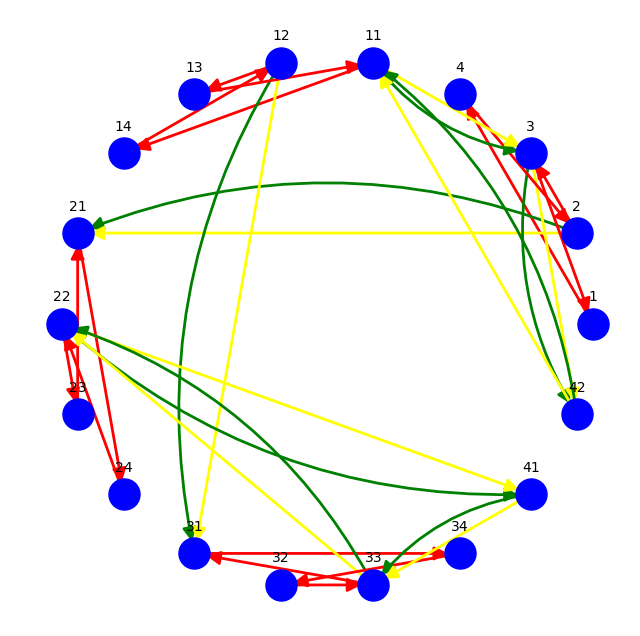

In [109]:
draw_graph(Y2)

If you would like to inspect the connected components of $\beta(Y_1)\otimes_U Y_1$ you would execut the code below.

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
This connected component is a subgraph of  Y2 . There are also  0  components that only contain red edges in this fiber product and  0  connected components that are subgraphs of a green-yellow triangle
[[((22, 11), (13, 14)), ((1, 14), (4, 22)), ((3, 11), (1, 14)), ((22, 4), (13, 12)), ((12, 13), (3, 11)), ((12, 1), (3, 4)), ((11, 3), (14, 1)), ((4, 22), (12, 13)), ((13, 14), (11, 22)), ((3, 4), (1, 12)), ((1, 12), (4, 3)), ((4, 3), (12, 1)), ((13, 12), (11, 3)), ((14, 13), (22, 11)), ((14, 1), (22, 4)), ((11, 22), (14, 13))], [((12, 13), (11, 22)), ((12, 1), (11, 3)), ((13, 12), (22, 11)), ((1, 12), (3, 11))], [((12, 13), (11, 22)), ((12, 1), (11, 3)), ((13, 12), (22, 11)), ((1, 12), (3, 11))], [(12, 1), (3, 4), (22, 11), (4, 3), (14, 1), (12, 13), (1, 14), (11, 22), (14, 13), (3, 11), (1, 12), (13, 14), (4, 22), (11, 3), (22, 4), (13, 12)]]


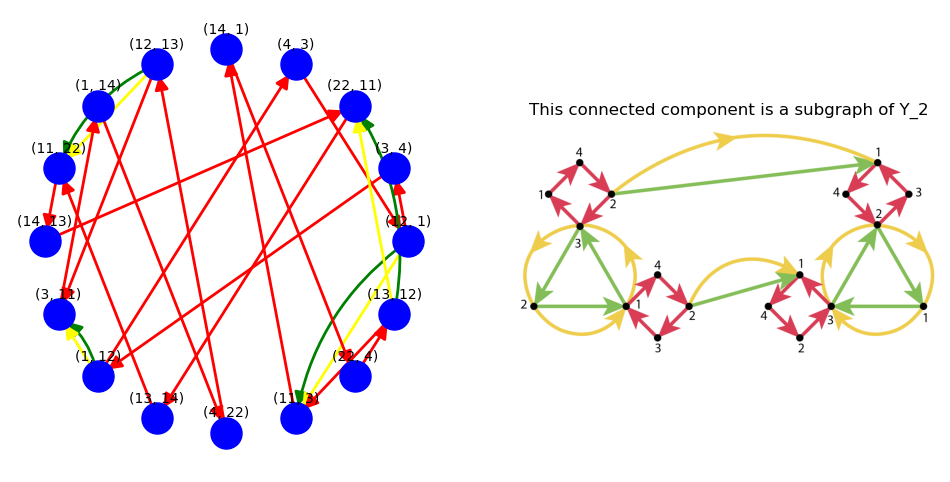

In [110]:
check_fiber(bY1, bY1, image_dict)